In [1]:
import networkx as nx
import matplotlib.pyplot as plt 
from IPython.display import SVG, display

import pygraphviz
# Note: to install pygraphviz on macOS, you need to first install graphviz using homebrew,
# and then tell pip to look for the graphviz headers and libraries in the homebrew directory:
#  brew install graphviz
#  python3 -m pip install \
#                --config-settings="--global-option=build_ext" \
#                --config-settings="--global-option=-I$(brew --prefix graphviz)/include/" \
#                --config-settings="--global-option=-L$(brew --prefix graphviz)/lib/" \
#                pygraphviz

# TODO:
# - use pydot instead of pygraphviz to render the graph, as pydot is a pure python library and is easier to install
# - move the SVG rendering to a git pre-commit hook so that people can change DOT files directly without needing
# to run this script to see the changes.

# README

[(1, 'start-node-yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy'), (2, 'end-node-zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'), (3, 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE'), (4, 'G'), (5, 'A'), (6, 'V'), (7, 'L'), (8, 'I'), (9, 'T'), (10, 'S'), (11, 'M'), (12, 'C'), (13, 'P'), (14, 'F'), (15, 'Y'), (16, 'W'), (17, 'H'), (18, 'K'), (19, 'R'), (20, 'D'), (21, 'E'), (22, 'N'), (23, 'Q')]


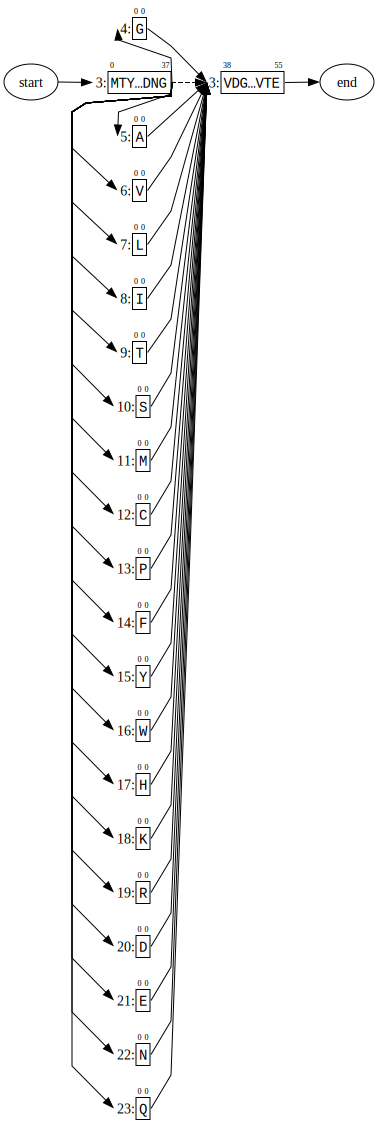

NodeDataView({'source': {'label': 'start'}, 'sink': {'label': 'end'}, '3': {'sequence': 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE'}, '4': {'sequence': 'G'}, '5': {'sequence': 'A'}, '6': {'sequence': 'V'}, '7': {'sequence': 'L'}, '8': {'sequence': 'I'}, '9': {'sequence': 'T'}, '10': {'sequence': 'S'}, '11': {'sequence': 'M'}, '12': {'sequence': 'C'}, '13': {'sequence': 'P'}, '14': {'sequence': 'F'}, '15': {'sequence': 'Y'}, '16': {'sequence': 'W'}, '17': {'sequence': 'H'}, '18': {'sequence': 'K'}, '19': {'sequence': 'R'}, '20': {'sequence': 'D'}, '21': {'sequence': 'E'}, '22': {'sequence': 'N'}, '23': {'sequence': 'Q'}})

In [ ]:
class BlockGraph:
    def __init__(self):
        self.graph = nx.DiGraph()
        self.graph.add_node('source', label='start')
        self.graph.add_node('sink', label='end')
        self.source_node = 'source'
        self.sink_node = 'sink'

    def add_node(self, sequence, node_id=None):
        """
        Adds a node to the graph.

        Parameters:
        sequence (str): The sequence associated with a node. Note that in the actual gen code the sequence is hashed to save space.
        """
        if node_id is None:
            # Start node IDs at 1, not counting source and sink
            node_id = self.graph.number_of_nodes() - 1 

        node_id = f'{node_id}'

        self.graph.add_node(node_id, sequence=sequence)
        return node_id
    
    def connect_to_source(self, node_id, to_pos=0):
        """
        Connects a node to the source node.

        Parameters:
        node_id (str): The ID of the node to connect to the source.
        to_pos (int): The position at which the edge arrives at node.
        """
        self.graph.add_edge(self.source_node, f'{node_id}', to_pos=to_pos, rank='same', constraint=False)

    def connect_to_sink(self, node_id, from_pos=-1):
        """
        Connects a node to the sink node.

        Parameters:
        node_id (int or str): The ID of the node to connect to the sink.
        from_pos (int): The position from which the edge departs from the node.
        """
        # Make sure the node_id is used as a string
        node_id = f'{node_id}'

        if from_pos == -1:
            from_pos = len(self.graph.nodes[node_id]['sequence'])-1
            
        self.graph.add_edge(node_id, self.sink_node, from_pos=from_pos, rank='same', constraint=False)

    def add_edge(self, source, target):
        """
        Adds an edge to the graph with port information stored as edge attributes.

        Parameters:
        source (tuple): A tuple containing the source node and the position from which the edge departs.
        target (tuple): A tuple containing the target node and the position at which the edge arrives.
        """
        self.graph.add_edge(f'{source[0]}', f'{target[0]}', from_pos=source[1], to_pos=target[1])

    def import_from_db(self, db, collection_name=None, sample_name=None, block_group_name=None):
        """
        Imports a graph from a gen database.

        Parameters:
        db (str): The gen sqlite3 .db file to import the graph from.
        collection_name (str): Filter by collection.
        sample_name (str): Filter by sample.
        graph_name (str): Filter by name.
        """
        con = sqlite3.connect(db_file)
        cur = con.cursor()

        # Build a query to get the edges
        query = '''SELECT source_node_id, source_coordinate, target_node_id, target_coordinate 
                 FROM edges
                 JOIN block_group_edges
                 ON block_group_edges.edge_id = edges.id
                 JOIN block_groups
                 ON block_groups.id = block_group_edges.block_group_id'''

        filters = []
        if collection_name:
            filters.append(f'block_groups.collection_name = "{collection_name}"')
        if sample_name:
            filters.append(f'block_groups.sample_name = "{sample_name}"')
        if block_group_name:
            filters.append(f'block_groups.name = "{block_group_name}"')

        if filters:
            query += ' WHERE ' + ' AND '.join(filters)

        cur.execute(query)
        edges = cur.fetchall()

        # Get the nodes
        node_ids = set([e[0] for e in edges] + [e[2] for e in edges])
        query = f'''SELECT id, sequence
        FROM nodes
        JOIN sequences
        ON nodes.sequence_hash = sequences.hash 
        WHERE nodes.id IN ({','.join(str(i) for i in node_ids)});'''
        cur.execute(query)
        nodes = cur.fetchall()
        
        # Look for the source and sink nodes
        source_node, sink_node = None, None
        for id, sequence in nodes:
            if sequence.startswith('start-'):
                source_node = id
                continue
            if sequence.startswith('end-'):
                sink_node = id
                continue

            self.add_node(sequence, node_id=id)

        # In the Rust code, from_pos is considered to be exclusive to the range of the block, 
        # so we need to subtract 1 to get the conventional position in the sequence.
        for source, from_pos, target, to_pos in edges:
            if source == source_node or from_pos == 0:
                self.connect_to_source(target, to_pos)
            elif target == sink_node:
                self.connect_to_sink(source, from_pos-1)
            else:
                self.add_edge((source, from_pos-1), (target, to_pos))
    
    def make_segment_graph(self):
        # Split up all nodes into segments (i.e. contiguous subsequences)
        segment_graph = nx.DiGraph()

        # Add source and sink nodes
        segment_graph.add_node('source', label='start', original_node='source', end=-1)
        segment_graph.add_node('sink', label='end', original_node='sink', start=0)

        # Iterate over the nodes in the graph and split them into segments
        for node in self.graph.nodes:
            if node in ['source', 'sink']:
                continue

            # Get ports from incoming and outgoing edges
            in_ports = [data.get('to_pos',0) for source, target, data in self.graph.in_edges(node, data=True)]
            out_ports = [data.get('from_pos',-1) for source, target, data in self.graph.out_edges(node, data=True)]

            sequence = self.graph.nodes[node].get('sequence', None)
            highlights = self.graph.nodes[node].get('highlights', [False] * len(sequence))

            # New segments are defined by the port node identifier, and a start and end position on the sequence the port node references.
            # Each "in port" needs to be present as a segment start, and each "out port" as a segment end.
            # All in ports are preceded by a segment end, an all out ports are followed by a segment start.
            # Position 0 and the last position are always segment starts and ends, respectively.
            starts = sorted(set([0] + in_ports + [x+1 for x in out_ports if x < (len(sequence)-1)]))
            ends = sorted(set(out_ports + [len(sequence)-1] + [x-1 for x in in_ports if x > 0])) 

            # Create the segments
            segments = []
            for i, j in zip(starts, ends):
                segment_id = f"{node}.{i}"
                segment_graph.add_node(segment_id, 
                                       sequence = sequence[i:j+1], 
                                       highlights = highlights[i:j+1],
                                       original_node = node, 
                                       start=i, end=j)
                segments.append(segment_id)

            # Create new edges between the segments to represent the reference sequence
            for i, j in zip(segments[:-1], segments[1:]):
                segment_graph.add_edge(i, j, reference=True)

        # Translate the original edges to new edges in the segment graph
        for source, target, port_data in self.graph.edges(data=True):
            source_end = port_data.get('from_pos', -1)
            target_start = port_data.get('to_pos', 0)
            
            # Find the segments that correspond to the source and target nodes, there should be only one of each
            source_segments = [node for node, segment_data in segment_graph.nodes(data=True) if segment_data['original_node'] == source and segment_data['end'] == source_end]
            target_segments = [node for node, segment_data in segment_graph.nodes(data=True) if segment_data['original_node'] == target and segment_data['start'] == target_start]
            assert len(source_segments) == 1
            assert len(target_segments) == 1

            segment_graph.add_edge(source_segments[0], target_segments[0], reference=False)

        return segment_graph

 
        
        

    def highlight_ranges(self, node_id, highlight_ranges):
        """
        Highlights specific ranges in a node's sequence.

        Parameters:
        node_id (int): The ID of the node to apply highlights to.
        highlight_ranges (list): A list of tuples containing the start and end positions of the ranges to highlight.
        """
        sequence = self.graph.nodes[node_id]['sequence']
        highlights = [False] * len(sequence)
        for start, end in highlight_ranges:
            for i in range(start, end):
                highlights[i] = True
        self.graph.nodes[node_id]['highlights'] = highlights

    def render_graph(self, filename=None, minimize=False, splines=True, rankdir = 'TD', hide_nodes=[]):
        # Create an AGraph to hold Graphviz attributes, based on the topology of the original graph
        agraph = pygraphviz.AGraph(directed=True)
        # Add the source and sink nodes first and last, respectively
        agraph.add_node('source', label='start')
        agraph.add_nodes_from([n for n in self.graph.nodes if n not in ['source', 'sink']])
        agraph.add_node('sink', label='sink')
        agraph.add_edges_from(self.graph.edges)

        # Remove nodes that are marked as hidden
        for node in hide_nodes:
            agraph.delete_node(node)

        for node in agraph.iternodes():
            if node in ['source', 'sink']:
                continue
            # Get the sequence and highlight information from the original graph
            node_data = self.graph.nodes[node]
            sequence = node_data['sequence']
            highlights = node_data.get('highlights', [False] * len(sequence))
            formatted_sequence = [f'<B>{c}</B>' if highlights[i] else c for i, c in enumerate(sequence)]

            if minimize and len(sequence) > 7:
                label = f"<<TABLE BORDER='0' CELLBORDER='1' CELLSPACING='0' CELLPADDING='5'><TR>"
                label += f"<TD BORDER='0' PORT='caption'>{node}: </TD>"
                # Only show the first and last 3 elements, and ports that are connected to other nodes
                visible_ports = set(list(range(0,len(sequence))[:3]) + list(range(0,len(sequence))[-3:]))
                for u, v, edge_data in self.graph.in_edges(node, data=True):
                    visible_ports.add(edge_data['to_pos'])
                for u, v, edge_data in self.graph.out_edges(node, data=True):
                    visible_ports.add(edge_data['from_pos'])
                visible_ports = sorted(visible_ports)

                # Start of a list that contains each port of the node, with ellipses between ports that are not sequential
                labeled_sequence = [f"<TD PORT='{visible_ports[0]}'><FONT FACE='Courier New'>{formatted_sequence[visible_ports[0]]}<SUB>{visible_ports[0]}</SUB></FONT></TD>"]
                if len(visible_ports) > 1 and (visible_ports[1]-visible_ports[0]) > 1:
                    labeled_sequence.append("<TD>…</TD>")
                    
                # Loop over the connected ports in pairs of two, so that we can take into account the gaps between them.
                for a, b in zip(visible_ports, visible_ports[1:]):
                    if b - a > 1 and b != visible_ports[-1]:
                        labeled_sequence.append("<TD>…</TD>")
                    labeled_sequence.append(f"<TD PORT='{b}'><FONT FACE='Courier New'>{formatted_sequence[b]}<SUB>{b}</SUB></FONT></TD>")

                label += '\n'.join(labeled_sequence)
                label += "</TR></TABLE>>"
                
            else:
                label = f"<<TABLE BORDER='0' CELLBORDER='1' CELLSPACING='0'><TR>"
                label += f"<TD BORDER='0' PORT='caption' ALIGN='right'>{node}:</TD>"
                labeled_sequence = [f"<TD PORT='{i}'><FONT FACE='Courier New'>{c}</FONT></TD>" 
                                      for i, c in enumerate(formatted_sequence)]
                label += '\n'.join(labeled_sequence)
                label += "</TR></TABLE>>"

            node.attr['shape'] = 'none'
            node.attr['margin'] = 0
            node.attr['label'] = label

        for edge in agraph.iteredges():
            # Get the attributes from the corresponding edge in the original graph
            edge_data = self.graph.edges[edge[0], edge[1]]

            # Set the constraint attribute to false for edges connected to the source or sink node
            if edge[0] == 'source' or edge[1] == 'sink':
                edge.attr['constraint'] = False

            # Connect the head and tail of each edge to the correct port
            # Note: you can also force the head and tail to be on one side of the port 
            # by appending ":s" or ":n" to the port name
            edge.attr['headport'] = f"{edge_data.get('to_pos','w')}"
            edge.attr['tailport'] = f"{edge_data.get('from_pos','e')}"
            # Cleaner look for the first edge coming out of the source node, or for left-right layouts in general):
            if (edge[0] == 'source' or rankdir == 'LR') and edge.attr['headport'] == '0':
                edge.attr['headport'] = 'caption'     

         # Set the graph-level attributes that will be used by the dot rendering engine
        agraph.graph_attr.update(rankdir=rankdir, splines='true' if splines else 'polyline')
        # Other useful arguments for dot (with defaults): ranksep=0.5 searchsize=100 mclimit=10

        # Write the dot file to disk if a filename is provided
        if filename:
            agraph.write(f'{filename}.dot')

        # Draw the graph using graphviz and display it in the notebook
        agraph.layout(prog='dot')
        if filename:
            agraph.draw(f'{filename}.svg', prog='dot', format='svg')
            
        display(SVG(agraph.draw(prog='dot', format='svg')))

    def render_segment_graph(self, filename=None, minimize=False, splines = True, cluster_segments = True, rankdir = 'LR', hide_nodes=[]):
        # Todo: refactor to break out a node -> segment function instead of make_segment_graph
        sgraph = self.make_segment_graph()

        # Create an AGraph to hold Graphviz attributes, based on the topology of the original graph
        agraph = pygraphviz.AGraph(directed=True)
        # Add the source and sink nodes first and last, respectively
        agraph.add_node('source', label='start')
        agraph.add_nodes_from([n for n in sgraph.nodes if n not in ['source', 'sink']])
        agraph.add_node('sink', label='end')
        agraph.add_edges_from(sgraph.edges)
        
        # Remove nodes that are marked as hidden
        for node in hide_nodes:
            agraph.delete_node(node)

        for node in agraph.iternodes():
            if node in ['source', 'sink']:
                continue
            # Get the sequence and highlight information from the networkx graph
            node_data = sgraph.nodes[node]
            sequence = node_data['sequence']
            highlights = node_data.get('highlights', [False] * len(sequence))
            formatted_sequence = [f'<B>{c}</B>' if highlights[i] else c for i, c in enumerate(sequence)]
            origin = node_data['original_node']
            start = node_data.get('start', 0)
            end = node_data.get('end', len(sequence)-1)

            label = f"<<TABLE BORDER='0' CELLBORDER='1' CELLSPACING='0'><TR>"
            label += f"<TD BORDER='0'></TD>"
            label += f"<TD BORDER='0' ALIGN='LEFT'><FONT POINT-SIZE='8'>{start}</FONT></TD>"
            label += f"<TD BORDER='0' ALIGN='RIGHT'><FONT POINT-SIZE='8'>{end}</FONT></TD></TR>"
            label += f"<TR><TD BORDER='0' PORT='caption' ALIGN='right'>{origin}:</TD><TD PORT='seq' COLSPAN='2'>"
            if minimize and len(sequence) > 7:
                # Only show the first and last 3 elements
                label += f"<FONT FACE='Courier New'>{''.join(formatted_sequence[0:3])}…{''.join(formatted_sequence[-3:])}</FONT>"
            else:
                label += f"<FONT FACE='Courier New'>{''.join(formatted_sequence)}</FONT>"

            label += "</TD></TR></TABLE>>"  
            
            node.attr['shape'] = 'none'
            node.attr['margin'] = 0
            # Trim superfluous formatting tags from the label
            node.attr['label'] = label.replace('</B><B>', '')

        for edge in agraph.iteredges():
            # Get the attributes from the corresponding edge in the segment graph
            edge_data = sgraph.edges[edge[0], edge[1]]

            # If the edge is a reference edge, make it dashed
            if edge_data.get('reference', False):
                edge.attr['style'] = 'dashed'

            # Configure where the edges will connect to the nodes
            if edge[1] == 'sink':
                edge.attr['headport'] = 'w'
            else:
                edge.attr['headport'] = 'caption:w'

            # Configure where the edges will depart the nodes
            if edge[0] == 'source':
                edge.attr['tailport'] = 'e'
            else:
                edge.attr['tailport'] = 'seq:e'

        # Create clusters based on the original_node attribute
        if cluster_segments:
            origin_grouping = dict((node,[]) for node in self.graph.nodes)
            for node, node_data in sgraph.nodes(data=True):
                if node in hide_nodes:
                    continue
                origin_grouping[node_data['original_node']].append(node)

            for origin, segments in origin_grouping.items():
                if len(segments) == 1:
                    continue
                cluster = agraph.add_subgraph(name=f'cluster_{origin}')
                cluster.graph_attr.update(style='invis', label='', rank='same')
                for node in segments:
                    cluster.add_node(node)     


        # Set the graph-level attributes that will be used by the dot rendering engine
        agraph.graph_attr.update(rankdir=rankdir, splines='true' if splines else 'polyline')
        
        # Write the dot file to disk if a filename is provided
        if filename:
            agraph.write(f'{filename}.dot')

        # Draw the graph using graphviz and display it in the notebook
        agraph.layout(prog='dot')
        if filename:
            agraph.draw(f'{filename}.svg', prog='dot', format='svg')
            
        display(SVG(agraph.draw(prog='dot', format='svg')))

db_file = '../../examples/protein_engineering/protein_engineering.db'

G = BlockGraph()
G.import_from_db(db_file, sample_name='gb1_mut1')
G.render_segment_graph(minimize=True, splines=False, cluster_segments=True)


G.graph.nodes(data=True)

## Figure 1 & 2

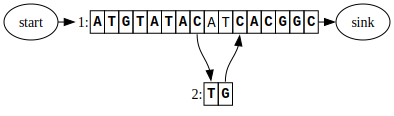

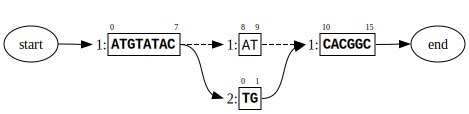

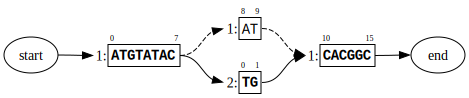

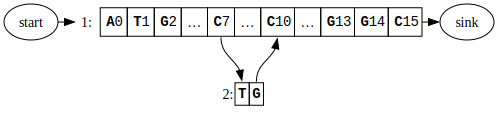

In [3]:
G = BlockGraph()

n1 = G.add_node('ATGTATACATCACGGC') # Derived from BBa_K1896001
n2 = G.add_node('TG')
G.connect_to_source(n1)
G.connect_to_sink(n1)
G.add_edge((n1, 7), (n2, 0))
G.add_edge((n2, 1), (n1, 10))
G.highlight_ranges(n1, [(0, 8), (10, 16)])
G.highlight_ranges(n1, [(0, 8), (10, 16)])
G.highlight_ranges(n2, [(0, 2)])

G.render_graph('figure_1', minimize=False)
G.render_segment_graph('figure_2', minimize=False)
G.render_segment_graph('figure_2_symmetrical', minimize=False, cluster_segments=False)
G.render_graph(minimize=True)

# Examples

## Protein Engineering

SELECT id, sequence
        FROM nodes
        JOIN sequences
        ON nodes.sequence_hash = sequences.hash 
        WHERE nodes.id IN (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27);


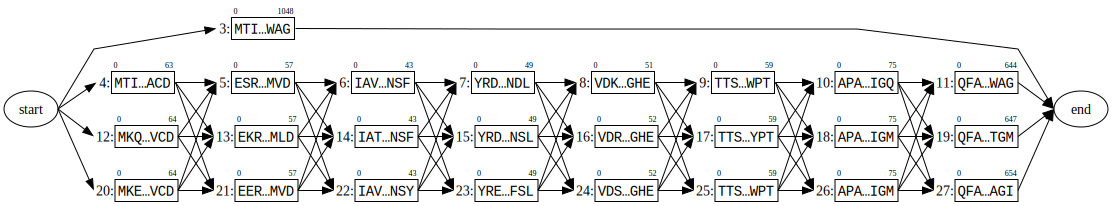

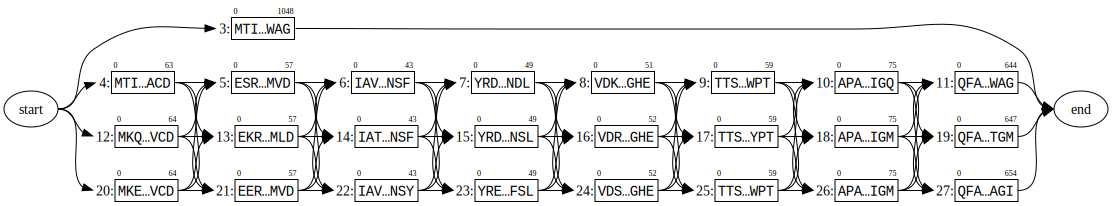

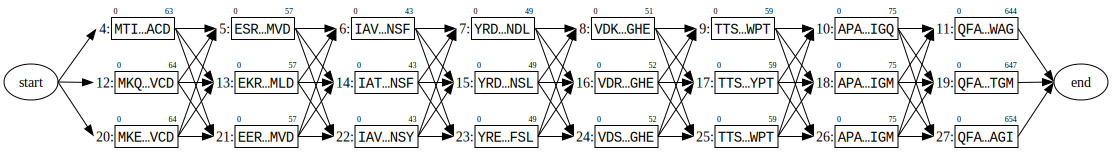

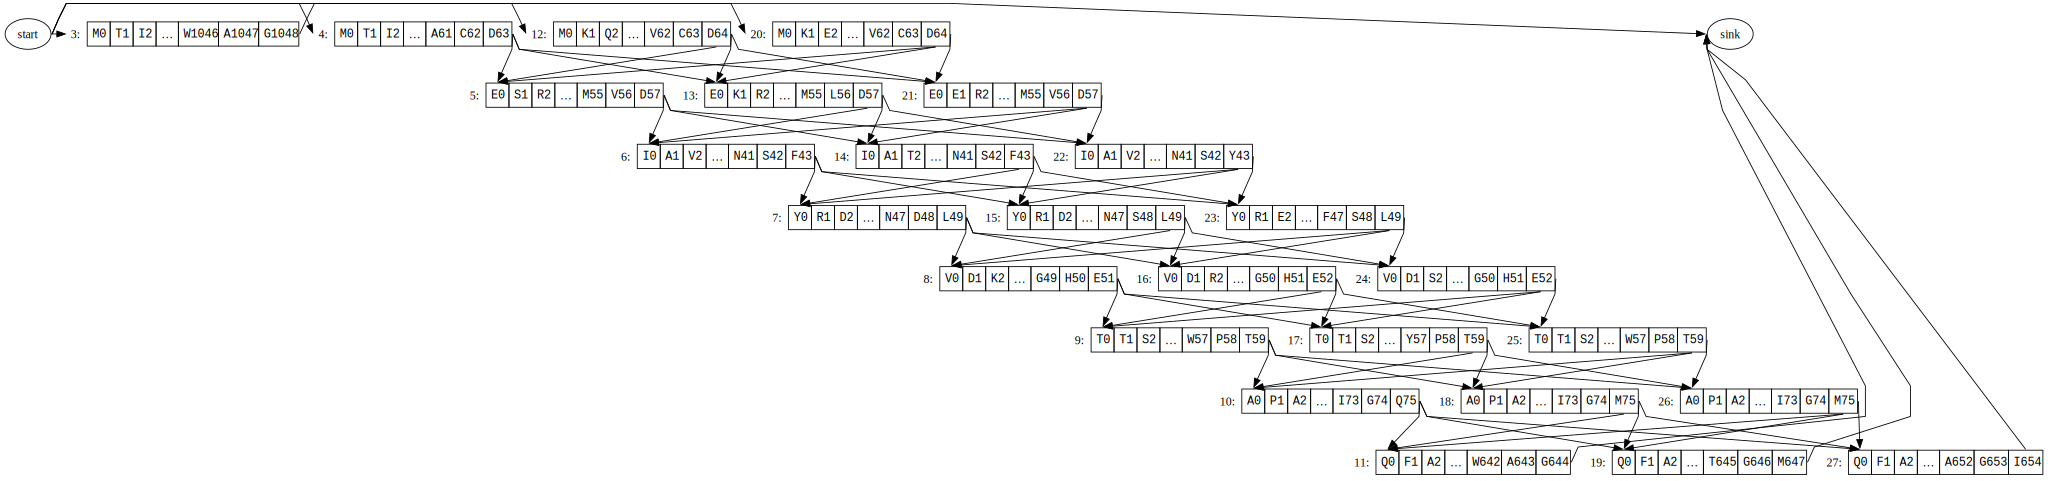

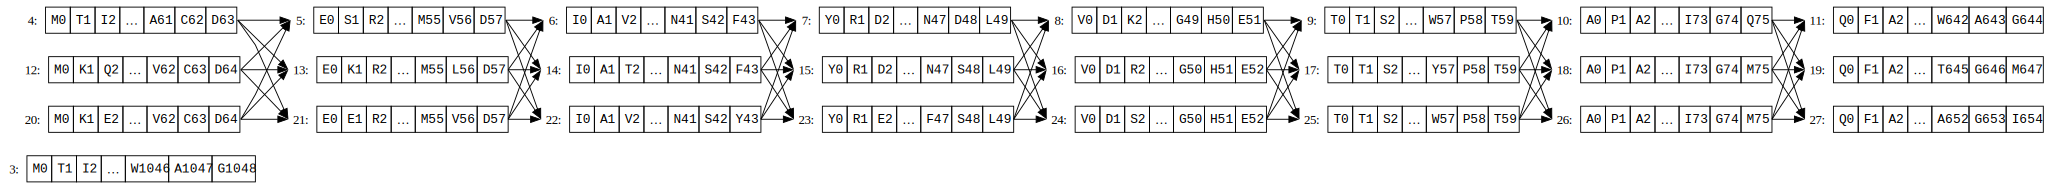

In [ ]:
db_file = '../../examples/protein_engineering/protein_engineering.db'

G = BlockGraph()
G.import_from_db(db_file)
G.render_segment_graph('protein_figure_1', minimize=True, splines=False, cluster_segments=True)
G.render_segment_graph(minimize=True, splines=True)
G.render_segment_graph(minimize=True, splines=False, hide_nodes=['3.0'])

G.render_graph(minimize=True, splines=False)
G.render_graph(minimize=True, splines=False, rankdir='LR', hide_nodes=['source', 'sink'])




In [30]:
G.graph.nodes(data=True)

NodeDataView({'source': {'label': 'start'}, 'sink': {'label': 'end'}, '3': {}, '2': {}, '13': {}, '23': {}, '15': {}, '21': {}, '7': {}, '11': {}, '8': {}, '20': {}, '10': {}, '4': {}, '5': {}, '18': {}, '19': {}, '16': {}, '17': {}, '6': {}, '9': {}, '12': {}, '14': {}, '22': {}})

In [33]:
db_file = '../../examples/protein_engineering/protein_engineering.db'

G = BlockGraph()
G.import_from_db(db_file, sample_name='gb1_mut1')
G.render_segment_graph(minimize=True, splines=False, cluster_segments=True)


G.graph.nodes(data=True)

TypeError: object of type 'NoneType' has no len()